In [1]:
!pip install segmentation-models
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1JJz7wj5D3qjreOPP1rgZua0WowhR8bGX
!pip install patool
import patoolib
patoolib.extract_archive('Segmentation.zip')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1JJz7wj5D3qjreOPP1rgZua0WowhR8bGX
To: /content/Segmentation.zip
100% 327M/327M [00:03<00:00, 90.6MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 2.9 MB/s eta 0:00:00
patool: Extracting Segmentation.zip ...
patool: running /usr/bin/7z x -o./Unpack_47kv3tux -- Segmentation.zip
patool: ... Segmentation.zip extracted to `Segmentation'.


'Segmentation'

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape,Input
from tensorflow import float32


def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [22]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# if __name__ == "__main__":
#     input_shape = (512, 512, 3)
    
#     model = build_unet(input_shape)
#     #model.summary()

In [4]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import segmentation_models as sm
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall, Precision

""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    
    split_size = int(len(images) * split)
    
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

Segmentation Models: using `keras` framework.


In [25]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "Unet.h5")
    csv_path = os.path.join("files", "Unet.csv")

    """ Dataset """
    dataset_path = "/content/Segmentation"
    images = sorted(glob(os.path.join(dataset_path, "images", "*.png")))
    print(type(images))
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(type(train_x))
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H,W,3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])
    model.summary()


<class 'list'>
<class 'list'>
Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_206 (Batch  (None, 256, 256, 64  256        ['conv2d_207[0][0]']             
 Normalizat

In [26]:
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.8596 - accuracy: 0.8349 - dice_coef: 0.1404 - iou: 0.0766 - recall_6: 0.8123 - precision_6: 0.0813
Epoch 1: val_loss improved from inf to 0.97485, saving model to files/Unet.h5
115/115 [==============================] - 108s 922ms/step - loss: 0.8596 - accuracy: 0.8349 - dice_coef: 0.1404 - iou: 0.0766 - recall_6: 0.8123 - precision_6: 0.0813 - val_loss: 0.9749 - val_accuracy: 0.9820 - val_dice_coef: 0.0251 - val_iou: 0.0127 - val_recall_6: 0.0000e+00 - val_precision_6: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.9718 - dice_coef: 0.2636 - iou: 0.1527 - recall_6: 0.7432 - precision_6: 0.3616
Epoch 2: val_loss did not improve from 0.97485
115/115 [==============================] - 108s 936ms/step - loss: 0.7364 - accuracy: 0.9718 - dice_coef: 0.2636 - iou: 0.1527 - recall_6: 0.7432 - precision_6: 0.3616 - val_loss: 0.9833 - val_accuracy: 0.73

In [5]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "resnet34_Unet_model.h5")
    csv_path = os.path.join("files", "resnet34_UNET_data.csv")

    """ Dataset """
    dataset_path = "/content/Segmentation"
    images = sorted(glob(os.path.join(dataset_path, "images", "*.png")))
    print(type(images))
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(type(train_x))
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    BACKBONE = 'resnet34'
    model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])
    model.summary()


<class 'list'>
<class 'list'>
Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
85521592/85521592 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, Non

In [6]:
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.9139 - accuracy: 0.8184 - dice_coef: 0.0861 - iou: 0.0452 - recall: 0.9389 - precision: 0.0840
Epoch 1: val_loss improved from inf to 0.96913, saving model to files/Double_Unet_model.h5
115/115 [==============================] - 51s 296ms/step - loss: 0.9139 - accuracy: 0.8184 - dice_coef: 0.0861 - iou: 0.0452 - recall: 0.9389 - precision: 0.0840 - val_loss: 0.9691 - val_accuracy: 0.9823 - val_dice_coef: 0.0308 - val_iou: 0.0157 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.9651 - dice_coef: 0.1879 - iou: 0.1044 - recall: 0.9198 - precision: 0.3313
Epoch 2: val_loss did not improve from 0.96913
115/115 [==============================] - 32s 275ms/step - loss: 0.8121 - accuracy: 0.9651 - dice_coef: 0.1879 - iou: 0.1044 - recall: 0.9198 - precision: 0.3313 - val_loss: 0.9704 - val_accuracy: 0.9823 - val_

In [8]:
  if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "vgg16_Unet_model.h5")
    csv_path = os.path.join("files", "vgg16_UNET_data.csv")

    """ Dataset """
    dataset_path = "/content/Segmentation"
    images = sorted(glob(os.path.join(dataset_path, "images", "*.png")))
    print(type(images))
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(type(train_x))
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    BACKBONE = 'vgg16'
    model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])
    model.summary()
    

<class 'list'>
<class 'list'>
Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
58889256/58889256 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None

In [9]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False),
    ]

model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.9272 - accuracy: 0.7126 - dice_coef: 0.0728 - iou: 0.0379 - recall_2: 0.9610 - precision_2: 0.0557
Epoch 1: val_loss improved from inf to 0.91230, saving model to files/vgg16_Unet_model.h5
115/115 [==============================] - 65s 470ms/step - loss: 0.9272 - accuracy: 0.7126 - dice_coef: 0.0728 - iou: 0.0379 - recall_2: 0.9610 - precision_2: 0.0557 - val_loss: 0.9123 - val_accuracy: 0.8991 - val_dice_coef: 0.0875 - val_iou: 0.0458 - val_recall_2: 0.9726 - val_precision_2: 0.1480 - lr: 1.0000e-04
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.8540 - accuracy: 0.9519 - dice_coef: 0.1460 - iou: 0.0791 - recall_2: 0.9327 - precision_2: 0.2626
Epoch 2: val_loss did not improve from 0.91230
115/115 [==============================] - 51s 444ms/step - loss: 0.8540 - accuracy: 0.9519 - dice_coef: 0.1460 - iou: 0.0791 - recall_2: 0.9327 - precision_2: 0.2626 - val_loss: 0.9146 - val_accuracy: 0.

In [11]:
  if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "inception_Unet_model.h5")
    csv_path = os.path.join("files", "inception_UNET_data.csv")

    """ Dataset """
    dataset_path = "/content/Segmentation"
    images = sorted(glob(os.path.join(dataset_path, "images", "*.png")))
    print(type(images))
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(type(train_x))
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    BACKBONE = 'inceptionv3'
    model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])
    model.summary()

<class 'list'>
<class 'list'>
Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormaliza

In [12]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False),
    ]

model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 0.8953 - accuracy: 0.8545 - dice_coef: 0.1047 - iou: 0.0557 - recall_4: 0.9220 - precision_4: 0.1015
Epoch 1: val_loss improved from inf to 0.92092, saving model to files/inception_Unet_model.h5
115/115 [==============================] - 58s 404ms/step - loss: 0.8953 - accuracy: 0.8545 - dice_coef: 0.1047 - iou: 0.0557 - recall_4: 0.9220 - precision_4: 0.1015 - val_loss: 0.9209 - val_accuracy: 0.8578 - val_dice_coef: 0.0790 - val_iou: 0.0412 - val_recall_4: 0.9154 - val_precision_4: 0.1042 - lr: 1.0000e-04
Epoch 2/30
115/115 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.9786 - dice_coef: 0.2821 - iou: 0.1667 - recall_4: 0.8970 - precision_4: 0.4574
Epoch 2: val_loss improved from 0.92092 to 0.72028, saving model to files/inception_Unet_model.h5
115/115 [==============================] - 44s 384ms/step - loss: 0.7179 - accuracy: 0.9786 - dice_coef: 0.2821 - iou: 0.1667 - recall_4: 0.8970 - pr

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
vgg=pd.read_csv("files/vgg16_UNET_data.csv")
resnet=pd.read_csv("files/resnet30for30epoch.csv")
inception=pd.read_csv("files/inception_UNET_data.csv")
unet=pd.read_csv("files/Unet.csv")

In [40]:
epoch=vgg.iloc[:,0:1].values
vgg_iou=vgg.iloc[:,10:11].values
resnet_iou=resnet.iloc[:,10:11].values
inception_iou=inception.iloc[:,10:11].values
unet_iou=unet.iloc[:,10:11].values

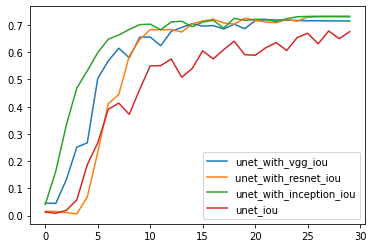

In [41]:
plt.plot(epoch,vgg_iou,label='unet_with_vgg_iou')
plt.plot(epoch,resnet_iou,label='unet_with_resnet_iou ')
plt.plot(epoch,inception_iou,label='unet_with_inception_iou')
plt.plot(epoch,unet_iou,label='unet_iou')
plt.legend()
plt.show()

In [42]:
vgg_train_loss=vgg.iloc[:,4:5].values
resnet_train_loss=resnet.iloc[:,4:5].values
inception_train_loss=inception.iloc[:,4:5].values
unet_train_loss=unet.iloc[:,4:5].values
vgg_val_loss=vgg.iloc[:,11:12].values
resnet_val_loss=resnet.iloc[:,11:12].values
inception_val_loss=inception.iloc[:,11:12].values
unet_val_loss=unet.iloc[:,11:12].values

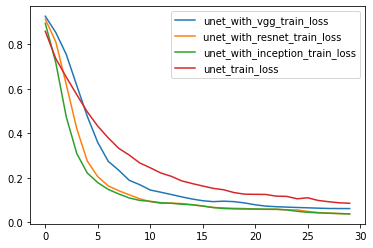

In [43]:
plt.plot(epoch,vgg_train_loss,label='unet_with_vgg_train_loss')
plt.plot(epoch,resnet_train_loss,label='unet_with_resnet_train_loss ')
plt.plot(epoch,inception_train_loss,label='unet_with_inception_train_loss')
plt.plot(epoch,unet_train_loss,label='unet_train_loss')
plt.legend()
plt.show()

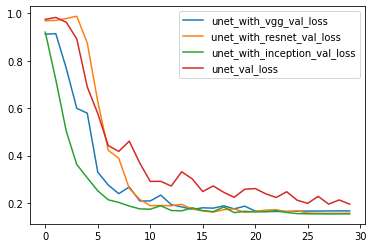

In [44]:
plt.plot(epoch,vgg_val_loss,label='unet_with_vgg_val_loss')
plt.plot(epoch,resnet_val_loss,label='unet_with_resnet_val_loss ')
plt.plot(epoch,inception_val_loss,label='unet_with_inception_val_loss')
plt.plot(epoch,unet_val_loss,label='unet_val_loss')
plt.legend()
plt.show()